# Import

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import norm

warnings.filterwarnings("ignore")

# Merge Movies and Ratings

In [82]:
ratings = pd.read_csv('moviesRatings/ratings.csv')
moviesMetadata = pd.read_csv('moviesRatings/movies_metadata.csv')
credits = pd.read_csv('moviesRatings/credits.csv')

In [83]:
# Creating functions to extract only cast name and director names from respective columns
# Converting the 'cast' column such that it only contains an array of the actors
def cast_convert(x):
    cast_names = []
    for i in ast.literal_eval(x):
        cast_names.append(i['name'])
    return cast_names

# Converting the 'crew' column such that it only contains an array of the director
def director_convert(x):
    director_names=[]
    for i in ast.literal_eval(x):
        if i['job']=='Director':
            director_names.append(i['name'])
        else:
            continue
    return director_names

In [84]:
# Applying the cast_convert function
credits['cast']=credits['cast'].apply(cast_convert)

In [85]:
# Applying the director_convert function
credits['director']=credits['crew'].apply(director_convert)

In [86]:
# Create new dataframe with movie_id, director and cast
cast_dir = credits[['id','director','cast']]

In [87]:
# Removing rows where there are empty lists
cast_dir = cast_dir[cast_dir['cast'].map(lambda d: len(d)) > 0]


In [88]:
cast_dir

,id,director,cast
0,862,[John Lasseter],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,8844,[Joe Johnston],"[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,15602,[Howard Deutch],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,31357,[Forest Whitaker],"[Whitney Houston, Angela Bassett, Loretta Devi..."
4,11862,[Charles Shyer],"[Steve Martin, Diane Keaton, Martin Short, Kim..."
...,...,...,...
45470,30840,[John Irvin],"[Patrick Bergin, Uma Thurman, David Morrissey,..."
45471,439050,[Hamid Nematollah],"[Leila Hatami, Kourosh Tahami, Elham Korda]"
45472,111109,[Lav Diaz],"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe..."
45473,67758,[Mark L. Lester],"[Erika Eleniak, Adam Baldwin, Julie du Page, J..."


In [89]:
# change id dtype to int
moviesMetadata['id'] = pd.to_numeric(moviesMetadata['id'], errors='coerce').astype('Int64')

# drop rows with id == NA
moviesMetadata = moviesMetadata.dropna(subset=["id"], axis=0) 

# inner join on movieID
merge_ratings = ratings.merge( moviesMetadata, left_on='movieId', right_on='id', how='inner')

# drop some columns 
merge_ratings = merge_ratings.drop(columns=['movieId', 'belongs_to_collection', 'homepage', 'poster_path', 'timestamp', 'video', 'status', 'original_title'], index=1)

# filter for users with more than 500 views
merge_ratings = merge_ratings[merge_ratings['userId'].isin(merge_ratings["userId"].value_counts()[merge_ratings["userId"].value_counts() > 500].index)] 
merge_ratings

,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
8099,229,3.0,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",2,tt0094675,fi,Taisto Kasurinen is a Finnish coal miner whose...,3.860491,"[{'name': 'Villealfa Filmproduction Oy', 'id':...","[{'iso_3166_1': 'FI', 'name': 'Finland'}]",1988-10-21,0.0,69.0,"[{'iso_639_1': 'fi', 'name': 'suomi'}, {'iso_6...",NaN,Ariel,7.1,44.0
8100,229,1.0,False,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,It's Ted the Bellhop's first night on the job....,9.026586,"[{'name': 'Miramax Films', 'id': 14}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-09,4300000.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,539.0
8101,229,1.0,False,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,"Nemo, an adventurous young clownfish, is unexp...",25.497794,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-05-30,940335536.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",There are 3.7 trillion fish in the ocean. They...,Finding Nemo,7.6,6292.0
8102,229,3.0,False,12800000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",16,tt0168629,en,"Selma, a Czech immigrant on the verge of blind...",10.684806,"[{'name': 'Fine Line Features', 'id': 8}, {'na...","[{'iso_3166_1': 'AR', 'name': 'Argentina'}, {'...",2000-05-17,40031879.0,140.0,"[{'iso_639_1': 'en', 'name': 'English'}]",You don't need eyes to see.,Dancer in the Dark,7.7,392.0
8103,229,1.0,False,92620000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",19,tt0017136,de,In a futuristic city sharply divided between t...,14.487867,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1927-01-10,650422.0,153.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",There can be no understanding between the hand...,Metropolis,8.0,666.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11437257,270887,5.0,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",166643,tt0021140,en,Navy divers clear the torpedo tube of a sunken...,0.662595,"[{'name': 'Fox Film Corporation', 'id': 5488}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1930-02-08,0.0,77.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Men Without Women,4.7,3.0
11437258,270887,4.0,False,0,[],167738,tt0116465,en,"A young, female filmmaker looks through her ca...",0.60839,[],[],1997-12-17,0.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",She was looking for something special. She fou...,Guy,6.0,1.0
11437259,270887,5.0,False,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 53,...",168712,tt0122202,en,The cockpit of a Boeing 747 is struck by light...,1.443855,"[{'name': 'Libra Pictures', 'id': 4106}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-10-13,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]","Terror at 35,000 feet, and falling.",Panic in the Skies,0.5,1.0
11437260,270887,5.0,False,0,"[{'id': 99, 'name': 'Documentary'}]",169864,tt2466830,en,"Each year, the world’s best 7 year-old golfers...",1.537704,[],[],2013-09-20,0.0,100.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",NaN,The Short Game,7.3,12.0


In [90]:
# copies from movies.ipynb

#convert to the right data type
merge_ratings["adult"] = merge_ratings["adult"].astype(bool)
merge_ratings['release_date'] = pd.to_datetime(merge_ratings['release_date'])
merge_ratings['genres'] = merge_ratings['genres'].apply(ast.literal_eval)
merge_ratings['production_companies'] = merge_ratings['production_companies'].apply(ast.literal_eval)
merge_ratings['production_countries'] = merge_ratings['production_countries'].apply(ast.literal_eval)
merge_ratings['spoken_languages'] = merge_ratings['spoken_languages'].apply(ast.literal_eval)

#convert the dictionaries into arrays of ids
merge_ratings['production_countries_name'] = merge_ratings['production_countries'].apply(lambda x : [item["iso_3166_1"] for item in x] if isinstance(x, list) else [])
merge_ratings['spoken_languages_name'] = merge_ratings['spoken_languages'].apply(lambda x : [item["iso_639_1"] for item in x] if isinstance(x, list) else [])

merge_ratings['production_companies_name'] = merge_ratings['production_companies'].apply(lambda x : [item["name"] for item in x] if isinstance(x, list) else [])
merge_ratings['genre_name'] = merge_ratings['genres'].apply(lambda x : [item["name"] for item in x] if isinstance(x, list) else [])
merge_ratings

,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,...,runtime,spoken_languages,tagline,title,vote_average,vote_count,production_countries_name,spoken_languages_name,production_companies_name,genre_name
8099,229,3.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",2,tt0094675,fi,Taisto Kasurinen is a Finnish coal miner whose...,3.860491,...,69.0,"[{'iso_639_1': 'fi', 'name': 'suomi'}, {'iso_6...",NaN,Ariel,7.1,44.0,[FI],"[fi, de]","[Villealfa Filmproduction Oy, Finnish Film Fou...","[Drama, Crime]"
8100,229,1.0,True,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,It's Ted the Bellhop's first night on the job....,9.026586,...,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,539.0,[US],[en],"[Miramax Films, A Band Apart]","[Crime, Comedy]"
8101,229,1.0,True,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,"Nemo, an adventurous young clownfish, is unexp...",25.497794,...,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",There are 3.7 trillion fish in the ocean. They...,Finding Nemo,7.6,6292.0,[US],[en],[Pixar Animation Studios],"[Animation, Family]"
8102,229,3.0,True,12800000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",16,tt0168629,en,"Selma, a Czech immigrant on the verge of blind...",10.684806,...,140.0,"[{'iso_639_1': 'en', 'name': 'English'}]",You don't need eyes to see.,Dancer in the Dark,7.7,392.0,"[AR, DK, FI, FR, DE, IS, IT, NL, NO, SE, GB, US]",[en],"[Fine Line Features, Zentropa Entertainments, ...","[Drama, Crime, Music]"
8103,229,1.0,True,92620000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",19,tt0017136,de,In a futuristic city sharply divided between t...,14.487867,...,153.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",There can be no understanding between the hand...,Metropolis,8.0,666.0,[DE],[xx],"[Paramount Pictures, Universum Film (UFA)]","[Drama, Science Fiction]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11437257,270887,5.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",166643,tt0021140,en,Navy divers clear the torpedo tube of a sunken...,0.662595,...,77.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Men Without Women,4.7,3.0,[US],[en],[Fox Film Corporation],"[Drama, Action]"
11437258,270887,4.0,True,0,[],167738,tt0116465,en,"A young, female filmmaker looks through her ca...",0.60839,...,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",She was looking for something special. She fou...,Guy,6.0,1.0,[],[en],[],[]
11437259,270887,5.0,True,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 53,...",168712,tt0122202,en,The cockpit of a Boeing 747 is struck by light...,1.443855,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]","Terror at 35,000 feet, and falling.",Panic in the Skies,0.5,1.0,[US],[en],"[Libra Pictures, Daniel L. Paulson Productions...","[TV Movie, Thriller]"
11437260,270887,5.0,True,0,"[{'id': 99, 'name': 'Documentary'}]",169864,tt2466830,en,"Each year, the world’s best 7 year-old golfers...",1.537704,...,100.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",NaN,The Short Game,7.3,12.0,[],"[fr, en]",[],[Documentary]


# Merge Movies, Ratings, Keywords

In [91]:
# Contains the movie plot keywords for our MovieLens movies collected from the TMDB 
keywords = pd.read_csv('moviesRatings/keywords.csv')
keywords # id corresponds to movieID

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [92]:
keywords

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [93]:
cast_kw = pd.merge(cast_dir, keywords, on="id", how="left")


In [94]:
cast_kw

,id,director,cast,keywords
0,862,[John Lasseter],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,[Joe Johnston],"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,[Howard Deutch],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,[Forest Whitaker],"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,[Charles Shyer],"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...
44004,30840,[John Irvin],"[Patrick Bergin, Uma Thurman, David Morrissey,...",[]
44005,439050,[Hamid Nematollah],"[Leila Hatami, Kourosh Tahami, Elham Korda]","[{'id': 10703, 'name': 'tragic love'}]"
44006,111109,[Lav Diaz],"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe...","[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
44007,67758,[Mark L. Lester],"[Erika Eleniak, Adam Baldwin, Julie du Page, J...",[]


In [95]:
merge_kw = merge_ratings.merge(cast_kw, left_on="id", right_on="id", how="left")
merge_kw

,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,...,title,vote_average,vote_count,production_countries_name,spoken_languages_name,production_companies_name,genre_name,director,cast,keywords
0,229,3.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",2,tt0094675,fi,Taisto Kasurinen is a Finnish coal miner whose...,3.860491,...,Ariel,7.1,44.0,[FI],"[fi, de]","[Villealfa Filmproduction Oy, Finnish Film Fou...","[Drama, Crime]",[Aki Kaurismäki],"[Turo Pajala, Susanna Haavisto, Matti Pellonpä...","[{'id': 240, 'name': 'underdog'}, {'id': 378, ..."
1,229,1.0,True,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,It's Ted the Bellhop's first night on the job....,9.026586,...,Four Rooms,6.5,539.0,[US],[en],"[Miramax Films, A Band Apart]","[Crime, Comedy]","[Allison Anders, Alexandre Rockwell, Robert Ro...","[Tim Roth, Antonio Banderas, Jennifer Beals, M...","[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na..."
2,229,1.0,True,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,"Nemo, an adventurous young clownfish, is unexp...",25.497794,...,Finding Nemo,7.6,6292.0,[US],[en],[Pixar Animation Studios],"[Animation, Family]",[Andrew Stanton],"[Albert Brooks, Ellen DeGeneres, Alexander Gou...","[{'id': 494, 'name': 'father son relationship'..."
3,229,3.0,True,12800000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",16,tt0168629,en,"Selma, a Czech immigrant on the verge of blind...",10.684806,...,Dancer in the Dark,7.7,392.0,"[AR, DK, FI, FR, DE, IS, IT, NL, NO, SE, GB, US]",[en],"[Fine Line Features, Zentropa Entertainments, ...","[Drama, Crime, Music]",[Lars von Trier],"[Björk, Catherine Deneuve, David Morse, Peter ...","[{'id': 30, 'name': 'individual'}, {'id': 246,..."
4,229,1.0,True,92620000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",19,tt0017136,de,In a futuristic city sharply divided between t...,14.487867,...,Metropolis,8.0,666.0,[DE],[xx],"[Paramount Pictures, Universum Film (UFA)]","[Drama, Science Fiction]",[Fritz Lang],"[Brigitte Helm, Alfred Abel, Gustav Fröhlich, ...","[{'id': 312, 'name': 'man vs machine'}, {'id':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831778,270887,5.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",166643,tt0021140,en,Navy divers clear the torpedo tube of a sunken...,0.662595,...,Men Without Women,4.7,3.0,[US],[en],[Fox Film Corporation],"[Drama, Action]",[John Ford],"[Frank Albertson, J. Farrell MacDonald, Warren...","[{'id': 339, 'name': 'submarine'}, {'id': 2682..."
831779,270887,4.0,True,0,[],167738,tt0116465,en,"A young, female filmmaker looks through her ca...",0.60839,...,Guy,6.0,1.0,[],[en],[],[],[Michael Lindsay-Hogg],"[Vincent D'Onofrio, Hope Davis]",[]
831780,270887,5.0,True,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 53,...",168712,tt0122202,en,The cockpit of a Boeing 747 is struck by light...,1.443855,...,Panic in the Skies,0.5,1.0,[US],[en],"[Libra Pictures, Daniel L. Paulson Productions...","[TV Movie, Thriller]",[Paul Ziller],"[Kate Jackson, Ed Marinaro, Erik Estrada, Maur...","[{'id': 952, 'name': 'lightning'}, {'id': 3800..."
831781,270887,5.0,True,0,"[{'id': 99, 'name': 'Documentary'}]",169864,tt2466830,en,"Each year, the world’s best 7 year-old golfers...",1.537704,...,The Short Game,7.3,12.0,[],"[fr, en]",[],[Documentary],[Josh Greenbaum],"[Edd Hall, Jennifer Van Horn]","[{'id': 271, 'name': 'competition'}, {'id': 59..."


In [96]:
print(f"""
intersection   {len(set(merge_ratings["id"]).intersection(set(keywords["id"])))}
ratings+movies {len(set(merge_ratings["id"]))}
keywords       {len(set(keywords["id"]))}
""")
# IDs in keywords are all present in ratings + movies df


intersection   7063
ratings+movies 7063
keywords       45432



## 55035 rows with blank keywords (remove from df)

In [97]:
merge_kw["keywords"].value_counts(dropna=False)

keywords
[]                                                                                                                                                                                   51599
NaN                                                                                                                                                                                   4737
[{'id': 187056, 'name': 'woman director'}]                                                                                                                                            3224
[{'id': 10183, 'name': 'independent film'}]                                                                                                                                           2648
[{'id': 238179, 'name': 'skab under tv'}, {'id': 238240, 'name': 'Øverste hylde'}, {'id': 238241, 'name': 'foran'}]                                                                   1744
                                                        

In [100]:
merge_kw = merge_kw.dropna(subset=["keywords"], axis=0) 

In [101]:
# drop rows without any keywords
merge_kw = merge_kw[merge_kw["keywords"] != "[]"].reset_index(drop=True)
merge_kw # No missing values under the cast & director column so don't need to remove

,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,...,title,vote_average,vote_count,production_countries_name,spoken_languages_name,production_companies_name,genre_name,director,cast,keywords
0,229,3.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",2,tt0094675,fi,Taisto Kasurinen is a Finnish coal miner whose...,3.860491,...,Ariel,7.1,44.0,[FI],"[fi, de]","[Villealfa Filmproduction Oy, Finnish Film Fou...","[Drama, Crime]",[Aki Kaurismäki],"[Turo Pajala, Susanna Haavisto, Matti Pellonpä...","[{'id': 240, 'name': 'underdog'}, {'id': 378, ..."
1,229,1.0,True,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,It's Ted the Bellhop's first night on the job....,9.026586,...,Four Rooms,6.5,539.0,[US],[en],"[Miramax Films, A Band Apart]","[Crime, Comedy]","[Allison Anders, Alexandre Rockwell, Robert Ro...","[Tim Roth, Antonio Banderas, Jennifer Beals, M...","[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na..."
2,229,1.0,True,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,"Nemo, an adventurous young clownfish, is unexp...",25.497794,...,Finding Nemo,7.6,6292.0,[US],[en],[Pixar Animation Studios],"[Animation, Family]",[Andrew Stanton],"[Albert Brooks, Ellen DeGeneres, Alexander Gou...","[{'id': 494, 'name': 'father son relationship'..."
3,229,3.0,True,12800000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",16,tt0168629,en,"Selma, a Czech immigrant on the verge of blind...",10.684806,...,Dancer in the Dark,7.7,392.0,"[AR, DK, FI, FR, DE, IS, IT, NL, NO, SE, GB, US]",[en],"[Fine Line Features, Zentropa Entertainments, ...","[Drama, Crime, Music]",[Lars von Trier],"[Björk, Catherine Deneuve, David Morse, Peter ...","[{'id': 30, 'name': 'individual'}, {'id': 246,..."
4,229,1.0,True,92620000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",19,tt0017136,de,In a futuristic city sharply divided between t...,14.487867,...,Metropolis,8.0,666.0,[DE],[xx],"[Paramount Pictures, Universum Film (UFA)]","[Drama, Science Fiction]",[Fritz Lang],"[Brigitte Helm, Alfred Abel, Gustav Fröhlich, ...","[{'id': 312, 'name': 'man vs machine'}, {'id':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775442,270887,2.0,True,0,"[{'id': 18, 'name': 'Drama'}]",144982,tt0115680,en,"Benny, a hapless grifter, is thrown off a trai...",0.404501,...,The Big Squeeze,5.0,1.0,[US],[en],[Zeta Entertainment],[Drama],[Marcus DeLeon],"[Lara Flynn Boyle, Danny Nucci, Peter Dobson, ...","[{'id': 3458, 'name': 'bartender'}, {'id': 159..."
775443,270887,4.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",147726,tt0027959,en,A fiery Cuban woman guides an emissary from th...,0.009507,...,A Message to Garcia,0.0,0.0,[US],[],[20th Century Pictures],"[Drama, Romance]",[George Marshall],"[Wallace Beery, Barbara Stanwyck, John Boles, ...","[{'id': 701, 'name': 'cuba'}]"
775444,270887,5.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",166643,tt0021140,en,Navy divers clear the torpedo tube of a sunken...,0.662595,...,Men Without Women,4.7,3.0,[US],[en],[Fox Film Corporation],"[Drama, Action]",[John Ford],"[Frank Albertson, J. Farrell MacDonald, Warren...","[{'id': 339, 'name': 'submarine'}, {'id': 2682..."
775445,270887,5.0,True,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 53,...",168712,tt0122202,en,The cockpit of a Boeing 747 is struck by light...,1.443855,...,Panic in the Skies,0.5,1.0,[US],[en],"[Libra Pictures, Daniel L. Paulson Productions...","[TV Movie, Thriller]",[Paul Ziller],"[Kate Jackson, Ed Marinaro, Erik Estrada, Maur...","[{'id': 952, 'name': 'lightning'}, {'id': 3800..."


## Extract keywords IDs as a new column

In [102]:
import ast
def extract_ids(json_string):
    # try:
    lst_of_ids = []
    lst_of_kw = ast.literal_eval(json_string)
    for d in lst_of_kw:
        id = d["id"]
        lst_of_ids.append(id)
    return lst_of_ids 

# get new column, each row contains list of the movie's keywords IDs
merge_kw['keywords_id'] = merge_kw.apply(lambda row: extract_ids(row["keywords"]), axis=1)

merge_kw[['keywords', 'keywords_id']]

,keywords,keywords_id
0,"[{'id': 240, 'name': 'underdog'}, {'id': 378, ...","[240, 378, 730, 1563, 1787, 10183, 13072]"
1,"[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...","[612, 613, 616, 622, 922, 2700, 12670, 160488,..."
2,"[{'id': 494, 'name': 'father son relationship'...","[494, 10026, 14785, 33759, 33760, 156948, 1794..."
3,"[{'id': 30, 'name': 'individual'}, {'id': 246,...","[30, 246, 279, 642, 730, 1328, 1382, 1415, 169..."
4,"[{'id': 312, 'name': 'man vs machine'}, {'id':...","[312, 1001, 1436, 1761, 2346, 2964, 3223, 3640..."
...,...,...
775442,"[{'id': 3458, 'name': 'bartender'}, {'id': 159...","[3458, 159607]"
775443,"[{'id': 701, 'name': 'cuba'}]",[701]
775444,"[{'id': 339, 'name': 'submarine'}, {'id': 2682...","[339, 2682, 3588]"
775445,"[{'id': 952, 'name': 'lightning'}, {'id': 3800...","[952, 3800, 10617]"


# Merge Movies, Ratings, Keywords, Sentiment Scores

In [103]:
sentiment = pd.read_csv("moviesRatings/reddit_sentiment_scores.csv")
sentiment

,movie_title,average_sentiment
0,Toy Story,0.109021
1,Jumanji,0.166635
2,Grumpier Old Men,0.145075
3,Waiting to Exhale,0.118957
4,Father of the Bride Part II,0.120473
...,...,...
52292,We,0.115973
52293,Window of the Soul,0.183833
52294,Bad Poems,-0.000223
52295,A Girl Thing,0.048279


In [104]:
result = pd.merge(merge_kw, sentiment, left_on="title", right_on="movie_title", how="left")

# drop rows without sentiment score
result = result.dropna(subset="average_sentiment")
result

,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,...,production_countries_name,spoken_languages_name,production_companies_name,genre_name,director,cast,keywords,keywords_id,movie_title,average_sentiment
1,229,1.0,True,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,It's Ted the Bellhop's first night on the job....,9.026586,...,[US],[en],"[Miramax Films, A Band Apart]","[Crime, Comedy]","[Allison Anders, Alexandre Rockwell, Robert Ro...","[Tim Roth, Antonio Banderas, Jennifer Beals, M...","[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...","[612, 613, 616, 622, 922, 2700, 12670, 160488,...",Four Rooms,0.102149
2,229,1.0,True,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,"Nemo, an adventurous young clownfish, is unexp...",25.497794,...,[US],[en],[Pixar Animation Studios],"[Animation, Family]",[Andrew Stanton],"[Albert Brooks, Ellen DeGeneres, Alexander Gou...","[{'id': 494, 'name': 'father son relationship'...","[494, 10026, 14785, 33759, 33760, 156948, 1794...",Finding Nemo,0.101589
3,229,3.0,True,12800000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",16,tt0168629,en,"Selma, a Czech immigrant on the verge of blind...",10.684806,...,"[AR, DK, FI, FR, DE, IS, IT, NL, NO, SE, GB, US]",[en],"[Fine Line Features, Zentropa Entertainments, ...","[Drama, Crime, Music]",[Lars von Trier],"[Björk, Catherine Deneuve, David Morse, Peter ...","[{'id': 30, 'name': 'individual'}, {'id': 246,...","[30, 246, 279, 642, 730, 1328, 1382, 1415, 169...",Dancer in the Dark,0.076770
4,229,1.0,True,92620000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",19,tt0017136,de,In a futuristic city sharply divided between t...,14.487867,...,[DE],[xx],"[Paramount Pictures, Universum Film (UFA)]","[Drama, Science Fiction]",[Fritz Lang],"[Brigitte Helm, Alfred Abel, Gustav Fröhlich, ...","[{'id': 312, 'name': 'man vs machine'}, {'id':...","[312, 1001, 1436, 1761, 2346, 2964, 3223, 3640...",Metropolis,0.085250
6,229,4.0,True,72000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",25,tt0418763,en,Jarhead is a film about a US Marine Anthony Sw...,9.997032,...,"[DE, US]","[en, es, ar, la]","[Universal Pictures, Neal Street Productions, ...","[Drama, War]",[Sam Mendes],"[Jamie Foxx, Jake Gyllenhaal, Scott MacDonald,...","[{'id': 1589, 'name': 'sniper'}, {'id': 4405, ...","[1589, 4405, 5174, 5175, 161236, 188114]",Jarhead,0.147666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906117,270887,5.0,True,0,"[{'id': 35, 'name': 'Comedy'}]",134881,tt1065307,en,"Alice is your typical modern woman, juggling h...",0.317873,...,[],[],[],[Comedy],[Daisy von Scherler Mayer],"[Molly Shannon, Steven Weber, Jake Beale]","[{'id': 187056, 'name': 'woman director'}]",[187056],More of Me,0.239920
906118,270887,3.0,True,0,[],138752,tt0014406,fr,"Experimental film, white specks and shapes gyr...",0.484709,...,[FR],[xx],[],[],[Man Ray],[Kiki of Montparnasse],"[{'id': 14893, 'name': 'art'}, {'id': 15216, '...","[14893, 15216]",Return to Reason,0.099320
906120,270887,5.0,True,500000,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",139715,tt1865346,en,A group of oddball high school students find t...,2.524224,...,[US],[en],[Gala Film],"[Comedy, Horror]",[Alex Craig Mann],"[Jacob Zachar, Alexa Nikolas, Christa Brittany...","[{'id': 6270, 'name': 'high school'}, {'id': 1...","[6270, 10183, 12377, 14687]",Detention of the Dead,0.063475
906123,270887,5.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",166643,tt0021140,en,Navy divers clear the torpedo tube of a sunken...,0.662595,...,[US],[en],[Fox Film Corporation],"[Drama, Action]",[John Ford],"[Frank Albertson, J. Farrell MacDonald, Warren...","[{'id': 339, 'name': 'submarine'}, {'id': 2682...","[339, 2682, 3588]",Men Without Women,0.131545


In [105]:
result.iloc[:5, 15:]

,spoken_languages,tagline,title,vote_average,vote_count,production_countries_name,spoken_languages_name,production_companies_name,genre_name,director,cast,keywords,keywords_id,movie_title,average_sentiment
1,"[{'iso_639_1': 'en', 'name': 'English'}]",Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,539.0,[US],[en],"[Miramax Films, A Band Apart]","[Crime, Comedy]","[Allison Anders, Alexandre Rockwell, Robert Ro...","[Tim Roth, Antonio Banderas, Jennifer Beals, M...","[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...","[612, 613, 616, 622, 922, 2700, 12670, 160488,...",Four Rooms,0.102149
2,"[{'iso_639_1': 'en', 'name': 'English'}]",There are 3.7 trillion fish in the ocean. They...,Finding Nemo,7.6,6292.0,[US],[en],[Pixar Animation Studios],"[Animation, Family]",[Andrew Stanton],"[Albert Brooks, Ellen DeGeneres, Alexander Gou...","[{'id': 494, 'name': 'father son relationship'...","[494, 10026, 14785, 33759, 33760, 156948, 1794...",Finding Nemo,0.101589
3,"[{'iso_639_1': 'en', 'name': 'English'}]",You don't need eyes to see.,Dancer in the Dark,7.7,392.0,"[AR, DK, FI, FR, DE, IS, IT, NL, NO, SE, GB, US]",[en],"[Fine Line Features, Zentropa Entertainments, ...","[Drama, Crime, Music]",[Lars von Trier],"[Björk, Catherine Deneuve, David Morse, Peter ...","[{'id': 30, 'name': 'individual'}, {'id': 246,...","[30, 246, 279, 642, 730, 1328, 1382, 1415, 169...",Dancer in the Dark,0.076770
4,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",There can be no understanding between the hand...,Metropolis,8.0,666.0,[DE],[xx],"[Paramount Pictures, Universum Film (UFA)]","[Drama, Science Fiction]",[Fritz Lang],"[Brigitte Helm, Alfred Abel, Gustav Fröhlich, ...","[{'id': 312, 'name': 'man vs machine'}, {'id':...","[312, 1001, 1436, 1761, 2346, 2964, 3223, 3640...",Metropolis,0.085250
6,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Welcome to the suck.,Jarhead,6.6,776.0,"[DE, US]","[en, es, ar, la]","[Universal Pictures, Neal Street Productions, ...","[Drama, War]",[Sam Mendes],"[Jamie Foxx, Jake Gyllenhaal, Scott MacDonald,...","[{'id': 1589, 'name': 'sniper'}, {'id': 4405, ...","[1589, 4405, 5174, 5175, 161236, 188114]",Jarhead,0.147666


In [106]:
result.columns

Index(['userId', 'rating', 'adult', 'budget', 'genres', 'id', 'imdb_id',
       'original_language', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'production_countries_name', 'spoken_languages_name',
       'production_companies_name', 'genre_name', 'director', 'cast',
       'keywords', 'keywords_id', 'movie_title', 'average_sentiment'],
      dtype='object')

In [107]:
# just saving locally so i can import for subsequent steps to cut down run time in the future
result.to_csv(".\\moviesRatings\\merged_dfs.csv", index=False)

# Further Data Processing and Modelling using 1 user

categorical variables: 'adult' (boolean), 'genres', 'original_language', 'production_companies',
       'production_countries', 'spoken_languages', 'keywords'  
quantitative variables: 'rating', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', average_sentiment  
text variables: 'overview', 'tagline', 'title'  
others: 'release_date'

In [108]:
chosenuser = 229

In [109]:
oneDs = merge_kw[merge_kw["userId"] == chosenuser]
print(oneDs.shape)
oneDs.head()

(557, 28)


,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,...,vote_average,vote_count,production_countries_name,spoken_languages_name,production_companies_name,genre_name,director,cast,keywords,keywords_id
0,229,3.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",2,tt0094675,fi,Taisto Kasurinen is a Finnish coal miner whose...,3.860491,...,7.1,44.0,[FI],"[fi, de]","[Villealfa Filmproduction Oy, Finnish Film Fou...","[Drama, Crime]",[Aki Kaurismäki],"[Turo Pajala, Susanna Haavisto, Matti Pellonpä...","[{'id': 240, 'name': 'underdog'}, {'id': 378, ...","[240, 378, 730, 1563, 1787, 10183, 13072]"
1,229,1.0,True,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,It's Ted the Bellhop's first night on the job....,9.026586,...,6.5,539.0,[US],[en],"[Miramax Films, A Band Apart]","[Crime, Comedy]","[Allison Anders, Alexandre Rockwell, Robert Ro...","[Tim Roth, Antonio Banderas, Jennifer Beals, M...","[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...","[612, 613, 616, 622, 922, 2700, 12670, 160488,..."
2,229,1.0,True,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,"Nemo, an adventurous young clownfish, is unexp...",25.497794,...,7.6,6292.0,[US],[en],[Pixar Animation Studios],"[Animation, Family]",[Andrew Stanton],"[Albert Brooks, Ellen DeGeneres, Alexander Gou...","[{'id': 494, 'name': 'father son relationship'...","[494, 10026, 14785, 33759, 33760, 156948, 1794..."
3,229,3.0,True,12800000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",16,tt0168629,en,"Selma, a Czech immigrant on the verge of blind...",10.684806,...,7.7,392.0,"[AR, DK, FI, FR, DE, IS, IT, NL, NO, SE, GB, US]",[en],"[Fine Line Features, Zentropa Entertainments, ...","[Drama, Crime, Music]",[Lars von Trier],"[Björk, Catherine Deneuve, David Morse, Peter ...","[{'id': 30, 'name': 'individual'}, {'id': 246,...","[30, 246, 279, 642, 730, 1328, 1382, 1415, 169..."
4,229,1.0,True,92620000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",19,tt0017136,de,In a futuristic city sharply divided between t...,14.487867,...,8.0,666.0,[DE],[xx],"[Paramount Pictures, Universum Film (UFA)]","[Drama, Science Fiction]",[Fritz Lang],"[Brigitte Helm, Alfred Abel, Gustav Fröhlich, ...","[{'id': 312, 'name': 'man vs machine'}, {'id':...","[312, 1001, 1436, 1761, 2346, 2964, 3223, 3640..."


## Dummies for keywords

In [110]:
# counting frequency of each keyword for this user
kw_value_counts = oneDs.explode("keywords_id")["keywords_id"].value_counts().sort_values(ascending=False).reset_index(name="count")
kw_value_counts

,keywords_id,count
0,9826,32
1,3737,31
2,10183,29
3,6054,28
4,2038,23
...,...,...
2840,180397,1
2841,180398,1
2842,5593,1
2843,5626,1


### Limit number of keywords dummies

In [111]:
# consider only top 1% frequency keywords. Or else most keywords only appear once, not meaningful and results in sparse matrix
kw_value_counts[:int(len(kw_value_counts) * 0.01)] # these are the keywords we will keep

,keywords_id,count
0,9826,32
1,3737,31
2,10183,29
3,6054,28
4,2038,23
5,9937,22
6,14819,21
7,187056,21
8,12670,20
9,212,19


In [112]:
kw_ids_to_remove = kw_value_counts[int(len(kw_value_counts) * 0.01):]["index"] # get a list of keywords ids to remove
kw_value_counts[int(len(kw_value_counts) * 0.01):] # these are the keywords we will remove

KeyError: 'index'

In [113]:
oneDs_selected_dummies = oneDs.copy()

# get dummies for all keywords
mlb = MultiLabelBinarizer()
OHE = mlb.fit_transform(oneDs_selected_dummies['keywords_id'])
OHE = pd.DataFrame(OHE)
prefix = "kw"
prefixed_strings = list(map(lambda s: prefix + str(s), mlb.classes_))
OHE.columns = prefixed_strings
oneDs_selected_dummies = pd.concat([oneDs_selected_dummies.reset_index(drop=True), OHE], axis=1)

# remove keywords with low frequency
oneDs_selected_dummies = oneDs_selected_dummies.drop(columns=[f"kw{idx}" for idx in kw_ids_to_remove])
oneDs_selected_dummies

NameError: name 'kw_ids_to_remove' is not defined

## Dummies for other categorical variables
copied from movies.ipynb

In [114]:
# copied from movies.ipynb

# binarize variables

# mlb_selected_features = MultiLabelBinarizer()
# OHE = mlb.fit_transform(oneDs_selected_dummies['production_countries_name'])
# OHE = pd.DataFrame(OHE)
# prefix = "ProdCountry_"
# prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
# OHE.columns = prefixed_strings
# oneDs_selected_dummies = pd.concat([oneDs_selected_dummies.reset_index(drop=True), OHE], axis=1)

# mlb = MultiLabelBinarizer()
# oneDs_selected_dummies["spoken_languages_name"] = oneDs_selected_dummies['spoken_languages_name'].replace(np.NaN, "")
# OHE = mlb.fit_transform(oneDs_selected_dummies['spoken_languages_name'])
# OHE = pd.DataFrame(OHE)
# prefix = "SpokenLang_"
# prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
# OHE.columns = prefixed_strings
# oneDs_selected_dummies = pd.concat([oneDs_selected_dummies.reset_index(drop=True), OHE], axis=1)

# mlb = MultiLabelBinarizer()
# oneDs_selected_dummies["production_companies_name"] = oneDs_selected_dummies['production_companies_name'].replace(np.NaN, "")
# OHE = mlb.fit_transform(oneDs_selected_dummies['production_companies_name'])
# OHE = pd.DataFrame(OHE)
# prefix = "ProdCompany_"
# prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
# OHE.columns = prefixed_strings
# oneDs_selected_dummies = pd.concat([oneDs_selected_dummies.reset_index(drop=True), OHE], axis=1)

mlb = MultiLabelBinarizer()
oneDs_selected_dummies["genre_name"] = oneDs_selected_dummies['genre_name'].replace(np.NaN, "")
OHE = mlb.fit_transform(oneDs_selected_dummies['genre_name'])
OHE = pd.DataFrame(OHE)
prefix = "Genre_"
prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
OHE.columns = prefixed_strings
oneDs_selected_dummies = pd.concat([oneDs_selected_dummies.reset_index(drop=True), OHE], axis=1)

oneDs_selected_dummies.head()

,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,...,Genre_History,Genre_Horror,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science Fiction,Genre_TV Movie,Genre_Thriller,Genre_War,Genre_Western
0,229,3.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",2,tt0094675,fi,Taisto Kasurinen is a Finnish coal miner whose...,3.860491,...,0,0,0,0,0,0,0,0,0,0
1,229,1.0,True,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,It's Ted the Bellhop's first night on the job....,9.026586,...,0,0,0,0,0,0,0,0,0,0
2,229,1.0,True,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,"Nemo, an adventurous young clownfish, is unexp...",25.497794,...,0,0,0,0,0,0,0,0,0,0
3,229,3.0,True,12800000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",16,tt0168629,en,"Selma, a Czech immigrant on the verge of blind...",10.684806,...,0,0,1,0,0,0,0,0,0,0
4,229,1.0,True,92620000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",19,tt0017136,de,In a futuristic city sharply divided between t...,14.487867,...,0,0,0,0,0,1,0,0,0,0


In [115]:
from pprint import pprint
pprint(list(oneDs_selected_dummies.columns))

['userId',
 'rating',
 'adult',
 'budget',
 'genres',
 'id',
 'imdb_id',
 'original_language',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'vote_average',
 'vote_count',
 'production_countries_name',
 'spoken_languages_name',
 'production_companies_name',
 'genre_name',
 'director',
 'cast',
 'keywords',
 'keywords_id',
 'kw30',
 'kw65',
 'kw74',
 'kw75',
 'kw83',
 'kw90',
 'kw100',
 'kw108',
 'kw110',
 'kw128',
 'kw131',
 'kw139',
 'kw187',
 'kw211',
 'kw212',
 'kw213',
 'kw220',
 'kw222',
 'kw233',
 'kw236',
 'kw237',
 'kw240',
 'kw242',
 'kw246',
 'kw248',
 'kw254',
 'kw255',
 'kw258',
 'kw260',
 'kw269',
 'kw270',
 'kw271',
 'kw276',
 'kw279',
 'kw290',
 'kw291',
 'kw293',
 'kw295',
 'kw310',
 'kw311',
 'kw312',
 'kw314',
 'kw321',
 'kw324',
 'kw328',
 'kw331',
 'kw339',
 'kw351',
 'kw374',
 'kw378',
 'kw380',
 'kw383',
 'kw385',
 'kw386',
 'kw387',
 'kw388',
 'kw3

# Visualisation

In [116]:
# copied from movies.ipynb

oneDs_selected_dummies['release_date_timestamp'] = oneDs_selected_dummies['release_date'].apply(lambda x : x.timestamp())

# list of dummy variables
selected_col = [col for col in oneDs_selected_dummies.columns if any(col.startswith(prefix) for prefix in ['Genre_', 'ProdCompany_', 'SpokenLang_', 'ProdCountry_', 'kw'])]

# fill NA with 0 under those dummy variables
oneDs_selected_dummies[selected_col] = oneDs_selected_dummies[selected_col].replace(np.NaN, 0)

# generate boolean target variable 
oneDs_selected_dummies['likeMovie'] = oneDs_selected_dummies['rating'] > 4
oneDs_selected_dummies.head()

allVars = ['rating', 'adult', 'budget', 'popularity', 'revenue', 'runtime', 'release_date_timestamp', 'vote_average', 'vote_count'] + selected_col
allPossibleVars = ['adult', 'budget', 'popularity', 'revenue', 'runtime', 'release_date_timestamp', 'vote_average', 'vote_count'] + selected_col
#Select columns
corrMat = oneDs_selected_dummies[allVars].corr()

## Density graph of Rating

Text(0.5, 1.0, 'density graph of rating')

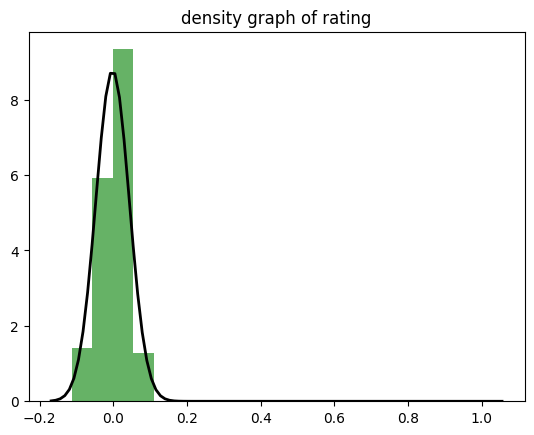

In [117]:
# copied from movies.ipynb

data = corrMat['rating']
data.dropna(inplace=True)

plt.hist(data, bins=20, density=True, alpha=0.6, color='g')
# plt.show()

mu, std = norm.fit(data)

# Plot the PDF of the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("density graph of rating")

In [118]:
oneDs_selected_dummies[allVars]

,rating,adult,budget,popularity,revenue,runtime,release_date_timestamp,vote_average,vote_count,kw30,...,Genre_History,Genre_Horror,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science Fiction,Genre_TV Movie,Genre_Thriller,Genre_War,Genre_Western
0,3.0,True,0,3.860491,0.0,69.0,5.933952e+08,7.1,44.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,True,4000000,9.026586,4300000.0,98.0,8.184672e+08,6.5,539.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,True,94000000,25.497794,940335536.0,100.0,1.054253e+09,7.6,6292.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,True,12800000,10.684806,40031879.0,140.0,9.585216e+08,7.7,392.0,1,...,0,0,1,0,0,0,0,0,0,0
4,1.0,True,92620000,14.487867,650422.0,153.0,-1.356221e+09,8.0,666.0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,2.0,True,0,6.941735,719968.0,105.0,1.169338e+09,5.9,76.0,0,...,0,1,0,0,0,0,0,1,0,0
553,5.0,True,20000000,14.348459,0.0,106.0,6.296832e+08,5.6,106.0,0,...,0,0,0,0,0,0,0,0,0,0
554,2.0,True,0,3.553763,0.0,90.0,-1.420848e+09,7.7,63.0,0,...,0,0,0,0,0,0,0,0,0,0
555,3.0,True,60000000,6.287072,0.0,125.0,9.765792e+08,6.5,530.0,0,...,0,0,0,0,1,0,0,0,0,0


## Correlation Matrix

In [119]:
import seaborn as sns
def get_corr_plot(df):
    corr = df.corr()
    sns.set_theme(rc = {'figure.figsize':(12,12)})
    sns.heatmap(corr, cmap='RdBu',annot=True, vmin=-1, vmax=1)
get_corr_plot(oneDs_selected_dummies[allVars]) # too many variables 

KeyboardInterrupt: 

In [ ]:
oneDs_selected_dummies[allVars]

,rating,adult,budget,popularity,revenue,runtime,release_date_timestamp,vote_average,vote_count,kw90,...,Genre_History,Genre_Horror,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science Fiction,Genre_TV Movie,Genre_Thriller,Genre_War,Genre_Western
0,3.0,True,0,7.832755,0.0,99.0,7.699968e+08,7.8,246.0,0,...,0,0,0,1,1,0,0,0,0,0
1,4.0,True,21000000,10.234919,227799884.0,105.0,7.408800e+08,6.5,630.0,0,...,0,0,0,0,1,0,0,0,0,0
2,2.0,True,24000000,11.697604,155721132.0,102.0,1.166573e+09,6.5,858.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,True,0,6.285574,29481428.0,109.0,8.558784e+08,5.8,133.0,0,...,0,0,0,0,1,0,0,0,0,0
4,4.0,True,0,3.824884,0.0,83.0,-1.015114e+09,6.8,42.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,3.0,True,60000000,12.915358,77920346.0,108.0,1.145405e+09,5.8,230.0,0,...,0,0,0,0,0,0,0,1,0,0
549,2.0,True,2000000,10.28123,0.0,85.0,6.324480e+08,5.8,18.0,0,...,0,1,0,0,0,1,0,1,0,0
550,2.0,True,14000000,7.469056,116000000.0,159.0,1.562112e+08,7.1,230.0,0,...,0,0,0,0,0,0,0,1,0,0
551,1.0,True,0,1.464329,0.0,100.0,8.156160e+07,6.4,27.0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df = oneDs_selected_dummies[allVars]
df.corr().abs().unstack()

rating         rating                    1.000000
               adult                          NaN
               revenue                   0.018796
               runtime                   0.047609
               release_date_timestamp    0.031827
                                           ...   
Genre_Western  Genre_Science Fiction     0.056627
               Genre_TV Movie            0.014821
               Genre_Thriller            0.072680
               Genre_War                 0.027632
               Genre_Western             1.000000
Length: 3025, dtype: float64

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, min_corr=0.7):

    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    result =  pd.DataFrame(au_corr.reset_index())
    result.columns = ["col1", 'col2', 'corr']
    return result[result["corr"] > min_corr]

print("Top Absolute Correlations")
high_corr = get_top_abs_correlations(oneDs_selected_dummies[allVars])
# high_corr["lower corr with Y"] = high_corr.apply(lambda row: row["col1"] if abs(np.corrcoef(oneDs_selected_dummies[allVars][row["col1"]], oneDs_selected_dummies[allVars]["Y"])[0][1]) < abs(np.corrcoef(oneDs_selected_dummies[allVars][row["col2"]], oneDs_selected_dummies[allVars]["Y"])[0][1]) else row["col1"], axis=1)
high_corr

Top Absolute Correlations


KeyError: ('kw34094', 'budget')

## Imbalanced data

In [ ]:
oneDs_selected_dummies["likeMovie"].value_counts()

False    519
True      34
Name: likeMovie, dtype: int64

# ML problem

Predict if the rating of a movie is above 4

In [ ]:
#import ML models
#linear  models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model

#categorization models
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report

In [ ]:
#categorical classifier

X = oneDs_selected_dummies[allPossibleVars]
y = oneDs_selected_dummies['likeMovie']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

gnb = GaussianNB().fit(X_train, y_train)
clfSvm = svm.SVC().fit(X_train, y_train)
clfTree = tree.DecisionTreeClassifier().fit(X_train, y_train)
neigh = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)

print("KNN accuracy:", neigh.score(X_test,y_test))
print("DTree accuracy: ",clfTree.score(X_test,y_test))
print("SVM accuracy: ",clfSvm.score(X_test,y_test))
print("NB accuracy: ",gnb.score(X_test,y_test))

KNN accuracy: 0.9712230215827338
DTree accuracy:  0.8848920863309353
SVM accuracy:  0.9712230215827338
NB accuracy:  0.9712230215827338


In [ ]:
# print(classification_report(y_test, gnb.predict(X_test)))
print("\nKNN:",  classification_report(y_test, neigh.predict(X_test)))
print("\nDTree: ", classification_report(y_test, clfTree.predict(X_test)))
print("\nSVM: ", classification_report(y_test, clfSvm.predict(X_test)))
print("\nNB: ", classification_report(y_test, gnb.predict(X_test)))


KNN:               precision    recall  f1-score   support

       False       0.97      1.00      0.99       135
        True       0.00      0.00      0.00         4

    accuracy                           0.97       139
   macro avg       0.49      0.50      0.49       139
weighted avg       0.94      0.97      0.96       139


DTree:                precision    recall  f1-score   support

       False       0.98      0.90      0.94       135
        True       0.07      0.25      0.11         4

    accuracy                           0.88       139
   macro avg       0.52      0.58      0.52       139
weighted avg       0.95      0.88      0.91       139


SVM:                precision    recall  f1-score   support

       False       0.97      1.00      0.99       135
        True       0.00      0.00      0.00         4

    accuracy                           0.97       139
   macro avg       0.49      0.50      0.49       139
weighted avg       0.94      0.97      0.96       13